In [18]:
# run this cell if using collab
from google.colab import drive
drive.mount('/gdrive')

# temporary solution
# get model state dir
!mkdir -p /content/model_states/ && cp -r -u /gdrive/MyDrive/seismo_datasets/model_states/.  /content/model_states/

!pip install datasets
!pip install kymatio # scattering

# get datasets from HF
url = "https://huggingface.co/datasets/mexalon/Synth_Seism/resolve/main/100k_train.hdf5"
!wget -nc {url}
url = "https://huggingface.co/datasets/mexalon/Synth_Seism/resolve/main/1k_val.hdf5"
!wget -nc {url}

# other from git
!git clone https://github.com/mexalon/Synth_wf_proc.git
!mkdir -p /content/imgs/ && cp -r -u Synth_wf_proc/imgs/. /content/imgs/

# the dataset and model states are also  available at https://drive.google.com/drive/folders/1hWSmVs57WeA2XBkUNjTgDhIPmksp6kbo?usp=sharing

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
File ‘100k_train.hdf5’ already there; not retrieving.

--2023-03-28 13:02:22--  https://huggingface.co/datasets/mexalon/Synth_Seism/resolve/main/1k_val.hdf5
Resolving huggingface.co (huggingface.co)... 34.203.133.210, 54.82.45.103, 52.2.178.255, ...
Connecting to huggingface.co (huggingface.co)|34.203.133.210|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/b4/5f/b45f43783e2d72cae033be8436fb41bc67f790908d328f6968b8da75ec745843/8b7a821a15a9b25235c82b75f29e3f1ca0f9f63474bf972ae374bf997a1b9b22?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%271k_val.hdf5%3B+filename%3D%221k_val.hdf5%22%3B&Expires=168

In [6]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from kymatio.torch import Scattering1D

import h5py
import numpy as np
import pandas as pd
import pywt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

cpu


## Постановка задачи для глубокого обучения
* Задача данной работы – построение метода анализа волновых форм сигналов, полученных в ходе микросейсмического мониторинга с использованием нейронной сети с целью локализации координат источников сейсмических событий, и их дифференциация. В рамках выполнения дипломной работы решалась подзадача – создание модели для выделения вступлений отдельных фаз на записях волновых форм группы приёмных станций.
* Микросейсмический мониторинг является одним из существующих методов анализа состояния исследуемого геофизического объекта: месторождения полезных ископаемых, крупномасштабные промышленные объекты и т. д. Он включает в себя систему датчиков, фиксирующих слабые сейсмические или акустические сигналы, систему сбора данных и алгоритмы их обработки. Основной задачей мониторинга является определение характеристик микросейсмического события: времени первого вступления, магнитуды, его месторасположения в пространстве.

### Существующие методы анализа волновых форм сейсмических сигналов
* Для решения задачи локации источников сейсмических событий в разное время было разработано большое число методов, которые можно поделить на две большие группы: методы на основе времени прихода волн и методов на основе волновых форм. Простейшие методы появились более ста лет назад, их дальнейшее усложнение происходило одновременно с ростом вычислительных возможностей ЭВМ. К первой группе методов можно отнести метод триангуляции, метод Гейгера и метод Grid Search [Karasözen, Karasözen, 2020; Milne, 2019]. Ко второй – метод наложения частичного сигнала, метод наложения обращенного сигнала (TRI), метод томографии волнового фронта (WT), метод полной инверсии волновой формы (FWI) [Li и др., 2020]. Общим их недостатком всех этих методов является существенная зависимость от скоростной модели среды.
* Нейронные сети для классификации сейсмических сигналов делятся на основе подхода к выделению признаков для последующего анализа в модели. Как правило для этого используются различные характеристические функции временного представления сигнала [Guo и др., 2021],  либо его частотно-временные представления.  Для классификации частотно-временных представлений сигналов наиболее успешно используются сверочные нейронные сете [Zhu и др., 2019], а также применяется transfer learning, при котором переобучаются существующие модели для анализа изображений [Zhu, Beroza, 2019].  По мере развития рекуррентных архитектур, они также стали активно применяться для обработки сейсмических сигналов. В настоящее время наиболее эффективно используются сети на основе трансформеров [Stepnov, Chernykh, Konovalov, 2021]. Также встречаются и различные сочетания перечисленных методов [Mousavi и др., 2020]. В целом, направление использования нейронных сетей для задач обработки сейсмических сигналов развивается в общем русле адаптации к данной задаче новых алгоритмов нейронных сетей по мере их появления в виде общедоступных программных продуктов.
* Задача локации источников микросейсмических событий до сих пор не имеет хорошего решения.  Микросейсмический мониторинг как правило проводится с использованием большой сети принимающих станций (сотни и иногда даже тысячи приборов). При этом качество записи каждой отдельной станции бывает очень плохое, что делает невозможным применение классических методов. Модель для работы с такими данными должна строиться на основе параллельного анализа всего массива записей. Количество анализируемых записей при этом может произвольно меняться.

1. Andén J., Mallat S. Deep scattering spectrum // IEEE Transactions on Signal Processing. 2014. Т. 62. № 16. С. 4114–4128.
2. Andreux M. и др. Kymatio: Scattering transforms in python // Journal of Machine Learning Research. 2020. Т. 21. С. 1–6.
3. Guo C. и др. AEnet: Automatic Picking of P-Wave First Arrivals Using Deep Learning // IEEE Transactions on Geoscience and Remote Sensing. 2021. Т. 59. № 6. С. 5293–5303.
4. Heimann S. и др. Pyrocko : A Versatile Software Framework for Seismology // 2018. Т. 20. С. 17314.
5. Karasözen E., Karasözen B. Earthquake location methods // GEM. 2020. Т. 11. № 1.
6. Li L. и др. Recent advances and challenges of waveform‐based seismic location methods at multiple scales // Reviews of Geophysics. 2020. Т. 58. № 1. С. 1–47.
7. Málek J., Horálek J., Janský J. One-Dimensional qP-Wave Velocity Model of the Upper Crust for the West Bohemia/Vogtland Earthquake Swarm Region // Studia Geophysica et Geodaetica 2005 49:4. 2005. Т. 49. № 4. С. 501–524.
8. Milne J. Earthquakes and other earth movements // Earthquakes and other Earth Movements. 2019. Т. LVI. С. 1–366.
9. Mousavi S. M. и др. Earthquake transformer—an attentive deep-learning model for simultaneous earthquake detection and phase picking // Nat Commun. 2020. Т. 11. № 1.
10. Stepnov A., Chernykh V., Konovalov A. The seismo-performer: A novel machine learning approach for general and efficient seismic phase recognition from local earthquakes in real time // Sensors. 2021. Т. 21. № 18.
11. Vaswani A. и др. Attention is all you need // Adv Neural Inf Process Syst. 2017. Т. 2017-Decem. № Nips. С. 5999–6009.
12. Zhu L. и др. Deep learning for seismic phase detection and picking in the aftershock zone of 2008 Mw7.9 Wenchuan Earthquake // Physics of the Earth and Planetary Interiors. 2019. Т. 293.
13. Zhu W., Beroza G. C. PhaseNet: A deep-neural-network-based seismic arrival-time picking method // Geophys J Int. 2019. Т. 216. № 1. С. 261–273.


## Данные для обучения модели
* Основным отличием предлагаемого подхода от большинства ранее представленных является использование синтетических волновых форм для формирования обучающей выборки. Преимущество такого подхода состоит в том, что для синтетических данных заранее известны все необходимые параметры каждого сейсмического события (время вступления, координаты источника, магнитуда, параметры механизма источника, скоростная модель среды). Это дает возможность создавать и обучать модели на данных, сформированных с учётом особенностей, характерных для заданного района проведения мониторинга, получаемые модели при этом могут обладать большей обобщающей способностью, чем обученные на реальных волновых формах. Кроме того, такой подход, в отличие от использования банков реальных волновых форм для обучения модели, исключает возможность искажения результатов, связанную с применением ручной разметки данных. Главным недостатком использования синтетических данных для обучения моделей связана с необходимостью адаптации получаемых моделей под реальные данные.
Синтетические волновые формы, использованные в данной работе, были созданы при помощи Pyrocko – набора библиотек для сейсмологического моделирования с открытым исходным кодом [Heimann и др., 2018].  Распространение сейсмических волн моделировалось для упруго-вязкой слоистой среды. Скоростная модель среды была взята из работы [Málek, Horálek, Janský, 2005]. Выбор определялся наличием в свободном доступе предварительно рассчитанного банка функций Грина, необходимого для получения волновых форм. Источники сейсмических сигналов моделировались двойной парой сил со случайным распределением направлений смещения (strike, deep, rake) и магнитудами, равномерно распределёнными в заданных границах (0–2). Эпицентры и глубины источников задавались случайным образом внутри области с радиусом 1.5 км и глубиной 1000 метров. Волновые формы (смещение) были получены для пяти станций (четыре симметрично расположены на расстоянии 500 метров от начала координат, и одна в центре ) для трёх каналов (два горизонтальных N, E и вертикальный Z) с частотой дискретизации 100 Гц, протяжённость каждой  записи – 4 секунды. Для каждой волновой формы были получены априорные моменты прихода p и s волны. В результате моделирования были сформированы обучающая и тестовая выборки из 106 и 103 событий соответственно (15 волновых форм в каждом). Сформированные данные хранились в hdf5 формате.

![microseismic modeling sketch](./imgs/microseism_cube.drawio.png "microseismic modeling sketch")

## Примеры извлечения данных из датасета

<KeysViewHDF5 ['events', 'sta0', 'sta1', 'sta2', 'sta3', 'sta4', 'stations_info']>
<KeysViewHDF5 ['arrivals', 'traces']>
<KeysViewHDF5 ['E', 'N', 'Z']>
0.8301578
[0.8301578  0.95753574 0.54443765 ... 0.8761627  0.60287815 1.0733824 ]


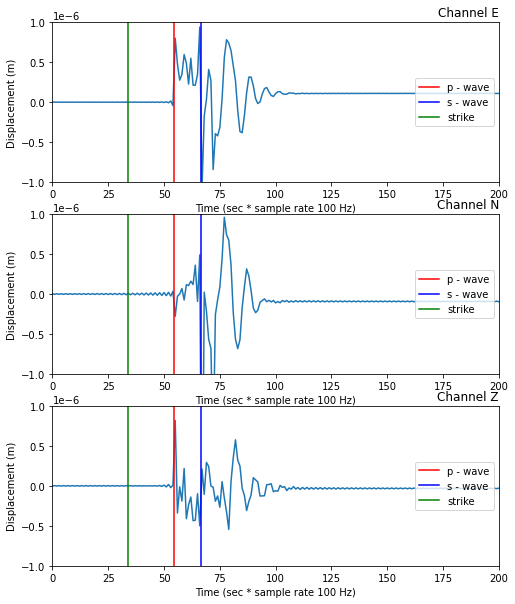

In [8]:
h5_path = '100k_train.hdf5'

with h5py.File(h5_path, 'r') as f:
    '''get root'''
    pp = f.keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of station 1 (sta1) items'''
    pp = f["sta1"].keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of traces on sta1'''
    pp = f["sta1/traces"].keys()
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get sta1 Z channel first trace'''
    pp = f["sta1/traces/Z"][0]
    # print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get its p arrival'''
    pp = f["sta1/arrivals/p"][0]
    print(pp)

with h5py.File(h5_path, 'r') as f:
    '''get list of p arrivals on sta1'''
    pp = f["sta1/arrivals/p"][:]
    print(pp)

'''how to get station_info DataFrame'''
si = pd.read_hdf(h5_path, '/stations_info')
si.head()

'''how to get events list'''
arr = pd.read_hdf(h5_path, '/events')
arr.head()

'''some using way'''
sample_rate = si['smpl_rate_hz'][0]

trace_no = 2 # event
sta = 1 # sta num
chnlz = 'ENZ' # channel codes

fig, ax = plt.subplots(3,1, figsize=(8,10))
with h5py.File(h5_path, 'r') as f:
    for ii, ch in enumerate(chnlz):
        ax[ii].set_xlim(0,200)
        ax[ii].set_ylim(-1e-6,1e-6)
        ax[ii].plot(f[f"sta{sta}/traces/{ch}"][trace_no])
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/p"][trace_no]*sample_rate, color='r', label = 'p - wave') # p-wave arrival
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/s"][trace_no]*sample_rate, color='b', label = 's - wave') # s-wave arrival
        ax[ii].axvline(x=f[f"sta{sta}/arrivals/strike"][trace_no]*sample_rate, color='g', label = 'strike') # strike moment
        ax[ii].legend(loc='right')
        ax[ii].set_title(f'Channel {ch}', loc='right')
        ax[ii].set_xlabel(f'Time (sec * sample rate {sample_rate} Hz)')
        ax[ii].set_ylabel(f'Displacement (m)')

plt.savefig(f'wavwforms_sampl.png', dpi = 300,  bbox_inches='tight', transparent=False)

### Определение класса датасета.
В качестве целевой переменной target формируется словарь с параметрами источника события, данными по приходам фаз, расстояниями от источника до каждой станции и набором прочих необходимых параметров. При преобразовании в переменную target  дополнительно дописывается one-hot представление времён прихода: два вектора (по вектору на каждую фазу), в корых метка 1 соответствует моменту прихода соответствующей фазы(p, s волны). В случае, когда момент прихода "попадает" между двумя точками волновой формы (почти всегда), метка делится пропорционально меду двумя ближайшими точками обратно пропорционально расстоянию до них. Такое представление необходимо, так как в дальнейшем эта модель будет модифицироваться для работы с непрерывными записями, в которых будет множество сигналов, иногда наложенных друг на друга. Поэтому удобно получать на выходе из модели временной ряд с условной вероятностью того, что в данной точке существует приход соответствующей фазы. 

In [9]:
# Dataset Class
class SynthSeism(torch.utils.data.Dataset):
    def __init__(self, h5_path, transforms):
        super().__init__()
        self.path = h5_path
        self.events = pd.read_hdf(self.path, '/events')
        self.stations = pd.read_hdf(self.path, '/stations_info')
        self.st_list = self.stations['name'].tolist()    # station names list
        self.chanels = self.stations['channel_codes'][0] # channels str: "ENZ"
        self.sampl_rate = self.stations['smpl_rate_hz'][0] # 100 Hz
        self.transforms = transforms # transforms func

        
    def __getitem__(self, idx):
        with h5py.File(self.path, 'r') as file:
            traces = np.array([np.array([file[f"{st}/traces/{ch}"][idx] for ch in self.chanels]) for st in self.st_list])
            arrivals = np.array([np.array([file[f"{st}/arrivals/{phase}"][idx] for phase in ['strike','p','s']]) for st in self.st_list])
            distances = np.array([self.get_dist(idx, st) for st in self.st_list])

        targets = {'source': self.events.iloc[idx].to_dict(),
                   'source_to_target_dist': distances, 
                   'arrivals': arrivals,
                   'params': {'s_rate': self.sampl_rate,
                             'stations': self.st_list,
                             'chanels': self.chanels}}

        return self.transforms(traces, targets)
    
    def get_dist(self, idx, st_name):
        # sourse to target distance
        ev = self.events.iloc[idx]
        e_xyz = [ev.x, ev.y, ev.depth]
              
        sta = self.stations[self.stations['name']==st_name]
        s_xyz  = [sta.x.item(), sta.y.item(), sta.depth.item()]

        dist = np.sqrt(np.sum([(e-s)**2 for e,s in zip(e_xyz,  s_xyz)]))
        return dist

    def __len__(self):
        return self.events.shape[0]     

    def collate_fn(self, batch):
        traces = [b[0] for b in batch]
        targets = [b[1] for b in batch]
        traces = torch.stack(traces, dim=0)
        return traces, targets

### Преобразования исходного сигнала.

Все классы фильтров принимают и возвращают пару traces, targets
* Вейвлет фильтрация высокочастотной осцилляции, присутствующей в сигнале и, по-видимому, являющейся артефактом моделирования. Для этого использовалось кратно-масштабное разложение – реконструкция сигнала с применением вейвлета Добеши 4-го порядка и занулением детализирующих коэффициентов первого уровня декомпозиции.
* Нормировка сигнала. При моделировании волновых форм задавались магнитуды от 0 до 2. Это привело к тому, что амплитуды разных записей различаются на несколько порядков. Нормировка производилась для каждого события, так что максимальная амплитуда сигнала в каждом событии была всегда равна 1. Параметр нормировки сохранялся для дальнейшего использования в модели.
* Преобразование векторов данных в формат Pytorch tensor.
* Преобразование времён моментов прихода фаз (p, s волны) в one-hot представление.
* Аугментация сигнала: наложение гауссовского шума малой амплитуды и спайков (будет обсуждаться в разделе, посвященном устойчивости модели к шуму).

Функция stack_transforms принимает список экземпляров классов трансформаций и возвращает функцию, которая их последовательно применяет к паре traces, targets.

In [10]:
class WtFilter():
    '''wt filtration: no cl == no filtering'''
    def __init__(self, wt='db2', cl = [], mode='constant'):
        self.wt = wt
        self.cl = cl # list of levels to cancel
        self.mode = mode

    def __call__(self, traces, targets):
        coeffs = pywt.wavedec(traces, wavelet=self.wt, mode=self.mode)
        for ii in self.cl:
            coeffs[ii] = np.zeros_like(coeffs[ii])
        
        traces = pywt.waverec(coeffs, self.wt)
        return traces, targets

class Normalizer():
    ''' 
    normalization
    every event (stack of 5*3 traces) is normalized on max ampl. separately 
    because of very large span of ampls. (~8 orders of degree).
    norm goes into targets['params']['signal_max']
    '''
    def __call__(self, traces, targets):
        max_abs = np.max(np.abs(traces))
        traces = traces/max_abs
        targets['params'].update({'signal_max': max_abs.item()})
        return traces, targets

class ToTensor():
    '''Transforms numpy to torch tensors'''
    def __call__(self, traces, targets):
        traces = torch.tensor(traces, dtype=torch.float)
        targets['arrivals'] = torch.tensor(targets['arrivals'], dtype=torch.float) 
        targets['source_to_target_dist'] = torch.tensor(targets['source_to_target_dist'], dtype=torch.float)
        return traces, targets

class ToOneHot():
    ''' 
    arrivals -> one hot tensors
    float values are sharing in proportion between adjacent points.
    this is for future expansion for working with continuous traces.
    result goes to targets['oh_arrivals']
    '''
    def __call__(self, traces, targets):
        tr_len = traces.shape[-1] # trace len
        s_rate = targets['params']['s_rate'] # 100 Hz
        arr = targets['arrivals'] # seconds
        arr = arr[:,1:]*s_rate # NO STRIKE INFO, just p and s  in points
        oh_arrivals = self.make_my_tricky_oh(arr, tr_len)
        targets.update({'oh_arrivals': oh_arrivals})  
        return traces, targets

    def make_my_tricky_oh(self, x, oh_size, sharing=False):
        # makes tensor of sparse vectors of arbitrary shape
        # my mind is blowing
        lo_int = torch.floor(x)
        hi_int = torch.ceil(x)

        if sharing:
            lo_val = hi_int - x # sharing 1 between adjacent points
            hi_val = x - lo_int
        else:
            lo_val = torch.ones_like(x) # both = 1
            hi_val = torch.ones_like(x) 

        xs = x.to_sparse_coo()
        ii = xs.indices()
        ss = xs.size()

        # new indieces
        flo_int = lo_int.view(1,-1)
        lo_ii = torch.cat((ii, flo_int))
        fhi_int = hi_int.view(1,-1)
        hi_ii = torch.cat((ii, fhi_int))
        new_ii = torch.cat((lo_ii, hi_ii), dim=-1)

        # new values
        lo_vv = lo_val.view(-1)
        hi_vv = hi_val.view(-1)
        new_vv = torch.cat((lo_vv, hi_vv), dim=-1)

        # new size
        new_ss = list(ss)
        new_ss.append(oh_size)

        # sparse to dense
        my_new_shiny_sparse_tensor = torch.sparse_coo_tensor(new_ii, new_vv, new_ss)
        my_georgious_oh = my_new_shiny_sparse_tensor.to_dense()
        return my_georgious_oh

class AddNoize():
    ''', and normalize'''
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, traces, targets):
        noize = self.sigma * torch.randn_like(traces)
        ntraces = torch.add(traces, noize)
        max_abs = torch.max(torch.abs(ntraces))
        traces = ntraces/max_abs
        return traces, targets

class AddCorrelatedNoize():
    '''
    This noize is correlated over the stack of channels:
    '''
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, traces, targets):
        corr_noise = self.sigma * (torch.sum(torch.randn_like(traces), dim=-2)/traces.shape[-2]).unsqueeze(-2).expand(traces.shape)
        ntraces = torch.add(traces, corr_noise)
        max_abs = torch.max(torch.abs(ntraces))
        traces = ntraces/max_abs
        return traces, targets

class Augmentation():
    '''
    add something to make my model more stable to noize
    random values in fraction random points
    '''
    def __init__(self, sigma=0.3, fraction = 0.1):
        self.sigma = sigma
        self.fraction = fraction

    def __call__(self, traces, targets):
        source = self.sigma * torch.randn_like(traces)
        mask = (0.1 * torch.randint_like(traces, 0, 10))<self.fraction
        traces.masked_scatter_(mask, source)
        return traces, targets

def stack_transforms(func_list):
    def performer(*args):
        for f in func_list:
           args = f(*args)
        return args
    return performer


### Разные нужные функции для отображения графиков

In [11]:
# plotting func
def plot_sta(st, traces, targets, targets_hat=None):
    chnlz = targets['params']['chanels']
    stations = targets['params']['stations']
    s_rate = targets['params']['s_rate']
    st_idx = stations.index(st)
    tr_len = traces.shape[-1]

    if targets_hat is None:
        targets_hat = targets['oh_arrivals']

    fig, ax = plt.subplots(len(chnlz),1, figsize=(12,12))
    for ii, ch in enumerate(chnlz):
        ax[ii].plot(traces[st_idx][ii])

        ax[ii].axvline(x=targets['arrivals'][st_idx][0]*s_rate, color='g', label = 'strike') # strike moment

        ax[ii].axvline(x=targets['arrivals'][st_idx][1]*s_rate, color='r', label = 'p - wave') # p-wave arrival
        ax[ii].fill_between(np.arange(tr_len), targets_hat[st_idx][0], color='r', alpha = 0.4)

        ax[ii].axvline(x=targets['arrivals'][st_idx][2]*s_rate, color='b', label = 's - wave') # s-wave arrival
        ax[ii].fill_between(np.arange(tr_len), targets_hat[st_idx][1], color='b', alpha = 0.4)
        ax[ii].set_ylabel(f'{st}:{ch}')

        ax[ii].set_xlim(0,200)
        ax[ii].set_ylim(-1,1)

def plot_event(traces, targets, targets_hat=None):
    for st in targets['params']['stations']:
        plot_sta(st, traces, targets, targets_hat)

def plot_metrics(metrics):
    fig, ax = plt.subplots(figsize=(4.33, 3))
    ax.plot(metrics['epoch'], metrics['loss']['train'], label='train')
    ax.plot(metrics['epoch'], metrics['loss']['val'],  label='val')
    ax.set_title('Loss', loc='center', fontsize=12)
    ax.set_xlabel('# Epoch', fontsize=12)
    ax.legend()

### Проверка даталоадера. На графиках - пример одного события - записи 5-ти 3-х канальных станций. Вертикальными линиями отмечены вермена события и прихода фаз. Сплошным тоном отображены их one-hot предстваления. 

CPU times: user 1.52 s, sys: 518 ms, total: 2.03 s
Wall time: 2.93 s


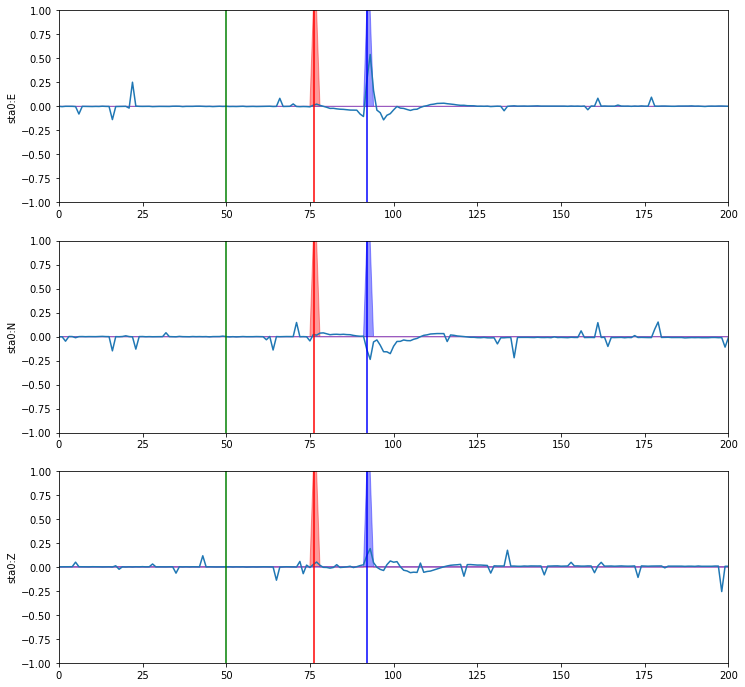

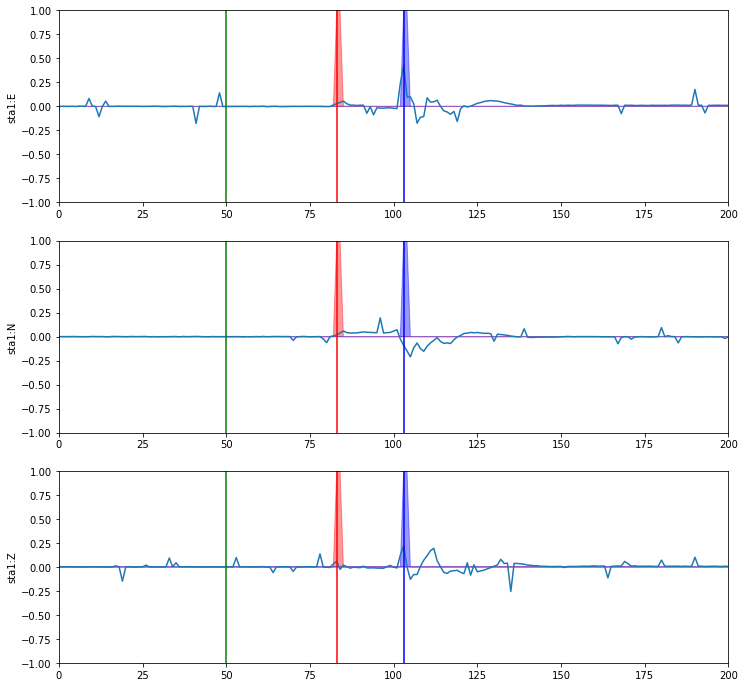

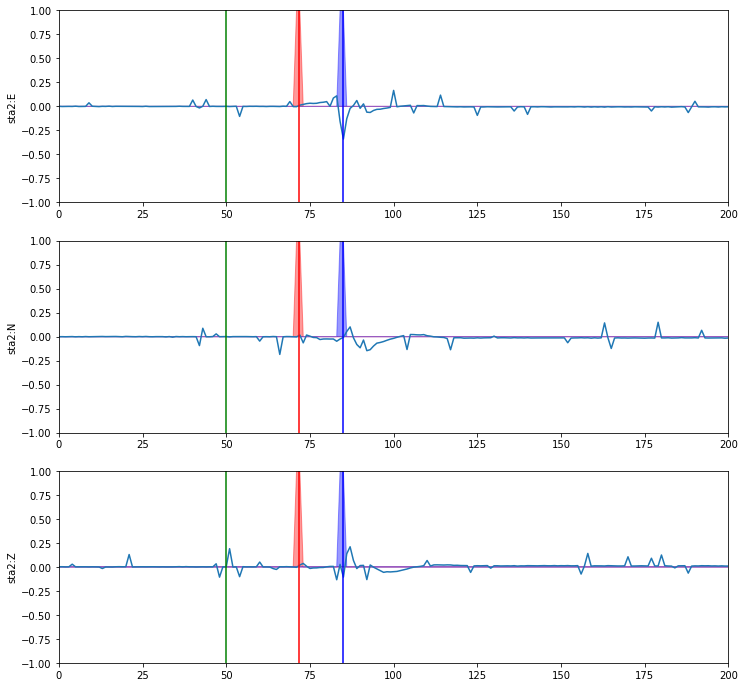

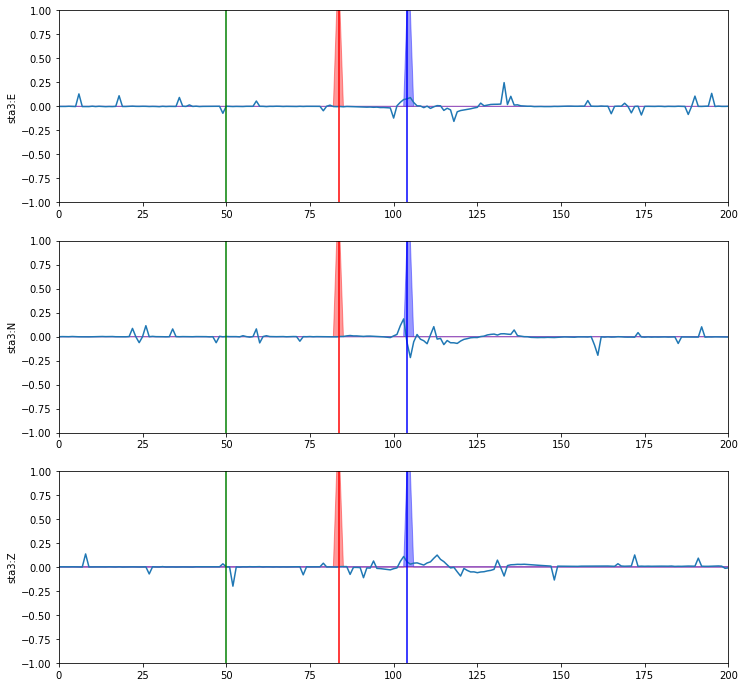

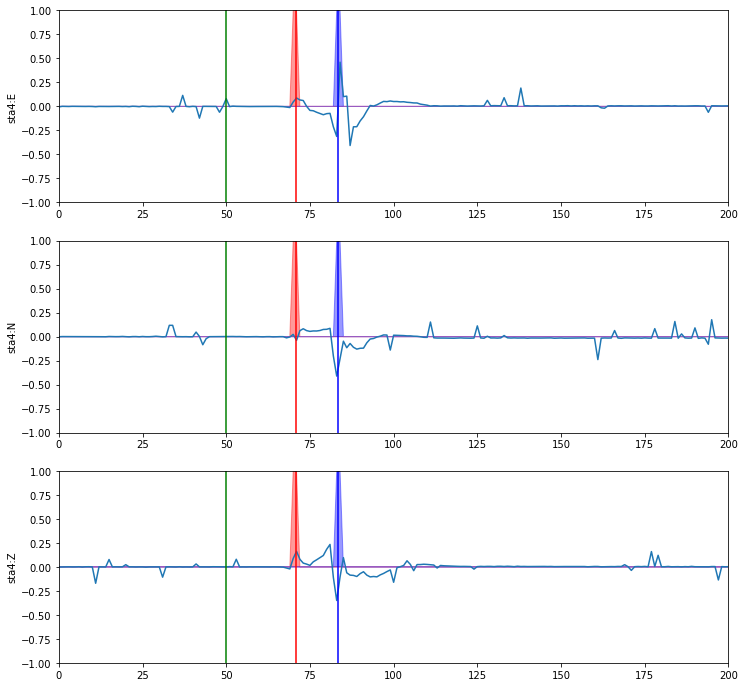

In [12]:
%%time
h5_path = '100k_train.hdf5'

transforms = stack_transforms([WtFilter(cl=[-1]),
                               Normalizer(),
                               ToTensor(), 
                               ToOneHot(), 
                               AddNoize(0.001),
                               AddCorrelatedNoize(0.001),
                               Augmentation(sigma=0.1, fraction = 0.1)])


dataset = SynthSeism(h5_path = h5_path, transforms=transforms)

# all is fine
dataloader = DataLoader(dataset=dataset,
                      batch_size=10,
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

for X, y in dataloader:
    plot_event(X[0], y[0])
    break

### Сама модель. 
В модели важна возможность применять её для произвольного количества станций, при этом, при обработке каждой отдельной записи, должны учитываться все прочие. 

* Для формирования пространства признаков используется Log-wavelet scattering transform исходного сигнала [Andén, Mallat, 2014]. Слой Wavelet Scattering (WS) формирует частотно-временное представление сигнала на основе вейвлет разложения, отчасти похожее на результат оконного преобразования Фурье. При этом WS обладает необходимыми свойствами устойчивости к искажениям исходного сигнала, сдвигам по времени и лучшего сохранения информации при разложении. Сам алгоритм представляет собой рекуррентную процедуру, в которой к исходному сигналу последовательно применяются операции вейвлет-пакетного разложения, взятия комплексного модуля и усреднения. С точки зрения нейронных сетей данный слой является аналогом сверточных слоев и операций пуллинга. Но, если в сверточном слое фильтры проходят процедуру обучения, то в случае использования WS они представлены набором вейвлетов, что снимает неопределённость, связанную с необходимостью обучения фильтров. В качестве реализации WS использовалась библиотека Kymatio [Andreux и др., 2020].
* В результате применения WS каждый сигнал преобразуется в 2D тензор с признаками. После этого прменяется двумерная свёртка с единичным размером ядра, преобразующая три канала записи каждой станции в один.
* Первый слой трансфомер энкодера. 2D представление каждого отдельно сигнала делится на временные фреймы и подаётся в трансформер энкодер для лучшего выделения области, в которой находится сигнал.
* Второй слой трансформер энкодера. Применяется к записям группы станций для обмена информации между ними.
* Выход слоя трансформера попадает на полносвязный слойb и сигмоиду. На выходе из модели для каждого события получается 2D тензор из one-hot векторов. Размерность тензора - (количство станций, количество фаз (p и s)).

Также в этом блоке переопределяется класс лосс функции. Это всё тот же BCELoss, но с большим штрафом за несовпадение с положительными метками. Это необходимо из-за несбалансированности целевых векторов: одно значение с меткой 1 на 399 нулевых значений.

![microseismic modeling sketch](./imgs/arr_model_1.drawio.png "The model structure")





In [13]:
class MySparseBCELoss(nn.Module):
    # Custom BCE loss. I need it because of unballanced targets
    def __init__(self, sparcity=1):
        super().__init__()
        self.sparcity = sparcity # approximate fraction of signals
        self.eps = 1e-6
        
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        # fraction of y==1 labels multiplied by (1/self.sparcity)
        my_custom_bceloss = - torch.mean((1/self.sparcity) * target * torch.log(input + self.eps) +  torch.log(1-input + self.eps)) 
        return my_custom_bceloss

class LogScat(nn.Module):
    '''
    Log-wavelet scattering transform. See https://www.kymat.io/index.html
    (..., trace vector) -> (...,  scat_shape 2D tensor)
    '''
    def __init__(self, J, rec_len, Q):
        super().__init__()
        self.scattering = Scattering1D(J, rec_len, Q).to(device)
        self.eps = 1e-6

    def forward(self, x):
        Sx = self.scattering(x)
        Sx[...,1:,:] = torch.log(torch.abs(Sx[...,1:,:]) + self.eps) # log for all coeffs except 0 order
        return Sx, self.scattering.meta()

class Conv_3_to_1(nn.Module):
    ''' 
    'Grayscale' chanels
    (..., ch num, scat_shape 2D tensor) -> (..., 1, scat_shape 2D tensor)
    '''
    def __init__(self, ch_in):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, 1, 1)
    
    def forward(self, x):
        sh_x = x.shape
        x = x.flatten(0,1)
        x = self.conv(x) 
        x = x.unflatten(0, (sh_x[0], sh_x[1]))
        return x

class OneTraceTransformerEncoder(nn.Module):
    '''
    Performs attention over each single trace 
    (batch, sta num, scattering 2D) -> (batch, sta num, scattering flat vector time, scattering flat vector order) -> (batch, sta num, scattering 2D)
    size of emb vector ==  size of scattering flat vector
    '''
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0]
        self.nheads = scat_shape[0]
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, 1, batch_first=True) # one head. emb size is unpredictable 
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        sh_x = x.shape 
        x = x.flatten(0,1) # batch, sta -> -1
        x = x.transpose(-1,-2) # scattering (order, time) <-> (time, order)   
        x = self.transformer_encoder(x)       
        x = x.transpose(-1,-2)
        x = x.unflatten(0, (sh_x[0], sh_x[1]))
        return x

class StaTransformerEncoder(nn.Module):
    '''
    Performs attention over the group of stantions
    (batch, sta num, scattering flat vector) -> (batch, sta num, emb vector)
    size of emb vector ==  size of scattering flat vector
    '''
    def __init__(self, scat_shape, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.emb_size = scat_shape[0] * scat_shape[1]
        self.nheads = scat_shape[0]
        self.encoder_layer = nn.TransformerEncoderLayer(self.emb_size, self.nheads, batch_first=True) # 16x50
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)
    
    def forward(self, x):
        return self.transformer_encoder(x)

class Fc(nn.Module):
    '''
    embeddings to outs (batch, sta num, emb vector) -> (batch, sta num, target tensor)
    '''
    def __init__(self, emb_size, rec_len):
        super().__init__()
        self.emb_size = emb_size
        self.rec_len = rec_len
        self.fc1 = nn.Linear(self.emb_size, 2*self.rec_len) 
        self.relu = nn.ReLU() # no leaky
        self.drop = nn.Dropout(0.5) #!!!
        self.fc2 = nn.Linear(2*self.rec_len, 2*self.rec_len) 
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.flatten(0,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x) # !!!
        x = self.fc2(x)
        x = self.sigm(x)
        x = x.view(bs, -1, 2, self.rec_len) # 2 phases 
        return x

class Arrivals(nn.Module):
    '''
    Model itself
    waveforms -> arrivals
    '''
    def __init__(self, chanels, rec_len, one_tr_attn_nlayer, sta_attn_nlayer, J=3, Q=4):
        super().__init__()
        self.ch = chanels
        self.rec_len = rec_len

        # scattering
        self.scattering = LogScat(J=J, rec_len=self.rec_len, Q=Q)
        self.scat_shape, self.meta = self.get_scat_shape()
        
        # conv 3 ch -> 1 ch
        self.conv_3ch = Conv_3_to_1(self.ch)
        
        # one trace cross attention
        self.one_tr_transf = OneTraceTransformerEncoder(self.scat_shape, one_tr_attn_nlayer) 

        # stantion cross attention
        self.sta_transf = StaTransformerEncoder(self.scat_shape, sta_attn_nlayer)
        self.emb_size =  self.sta_transf.emb_size  # equal to flat scatt size

        # fc 
        self.fc = Fc(self.emb_size, self.rec_len)

    def forward(self, x):
        x, meta = self.scattering(x) # scattering
        x = self.conv_3ch(x).squeeze(-3) # 3 ch to one
        x = self.one_tr_transf(x) # attention over each singl trace 
        x = x.flatten(-2,-1) # img to line
        x = self.sta_transf(x) # attention over the group of stantions
        x = self.fc(x)
        return x

    def get_scat_shape(self):
        # returns scattering output shape
        foo = torch.randn(self.rec_len).to(device)
        bar, meta = self.scattering(foo)
        return bar.shape, meta



## Функции для обучения модели выделения фаз.

In [14]:
def train_one_epoch(model, train_dl, test_dl):
    loaders = {'train': train_dl, 'val': test_dl}
    model_modes = {'train': model.train, 'val': model.eval}
    losses = {'train': [], 'val': []}
    for mode in ['train', 'val']:
        model_modes[mode]() # model to train() or eval()
        for X, y_list_of_dicts in tqdm(loaders[mode]):
            y = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
            X = X.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            if mode == 'train':
                optimizer.zero_grad()
                l.backward()
                optimizer.step()

        losses[mode] = l.item()
        
    return losses

def train_model(model, train_dl, test_dl):
    metrics = {'loss':{'train': [], 'val': []},
               'epoch': []} 
    model.to(device)
    for epoch in tqdm(range(epochs)):
        losses = train_one_epoch(model, train_dl, test_dl)
        metrics['epoch'].append(epoch)
        metrics['loss']['train'].append(losses['train'])
        metrics['loss']['val'].append(losses['val'])
        if epoch % 1 == 0:
            print(f"Epoch {epoch}:: train loss: {metrics['loss']['train'][-1]:.04f}, val loss: {metrics['loss']['val'][-1]:.04f}")

    return metrics

def eval_model(model, test_dl):
    model.requires_grad_(False)
    model.to(device)
    model.eval()
    for X, y_list_of_dicts in tqdm(test_dl):
        y = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
        X = X.to(device)
        y_hat = model(X)
        l = loss(y_hat, y)

    return l.item()

## Блок обучения и валидации модели. 

In [15]:
# model
model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)

# loading last save
pt_path = 'model_states/Aug_1_e3_03_01_state_dict_03_23_2023__17_36_28.pt'

# model.load_state_dict(torch.load(pt_path, map_location=torch.device(device)))

In [19]:
%%time
train_h5_path = '100k_train.hdf5'
test_h5_path = '1k_val.hdf5'

train_transforms = stack_transforms([WtFilter(cl=[-1]),
                               Normalizer(),
                               ToTensor(),
                               ToOneHot(),
                               AddNoize(0.001),
                               AddCorrelatedNoize(0.001),
                               Augmentation(sigma=0.1, fraction = 0.1)])

test_transforms = stack_transforms([WtFilter(cl=[-1]),
                                      Normalizer(), 
                                      ToTensor(), 
                                      ToOneHot(),])

train = SynthSeism(h5_path = train_h5_path, transforms=train_transforms)
test = SynthSeism(h5_path = test_h5_path, transforms=test_transforms)

# this is for testing
# train = torch.utils.data.Subset(train, torch.randperm(2000).tolist())

train_dl = DataLoader(dataset=train,
                      batch_size=100,
                      shuffle=True,
                      collate_fn=dataset.collate_fn, 
                      )

test_dl = DataLoader(dataset=test,
                      batch_size=len(test),
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

# loss
loss =  MySparseBCELoss(sparcity = 0.0025) # 1 signal on 400 points

# optimizer
epochs = 30
lr = 0.0001 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = train_model(model, train_dl, test_dl)
plot_metrics(metrics)

#saving path
# !mkdir -p /content/model_states/
pt_path = 'model_states/'+'Aug_1_2xNoise_01_01_Drops_'+'state_dict_'+ datetime.now().strftime("%m_%d_%Y__%H_%M_%S") +'.pt'
torch.save(model.state_dict(), pt_path)

# copy it to gdrive
# !mkdir -p /gdrive/MyDrive/seismo_datasets/model_states/ && cp {pt_path} /gdrive/MyDrive/seismo_datasets/model_states/

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Проверка модели

  0%|          | 0/1 [00:00<?, ?it/s]

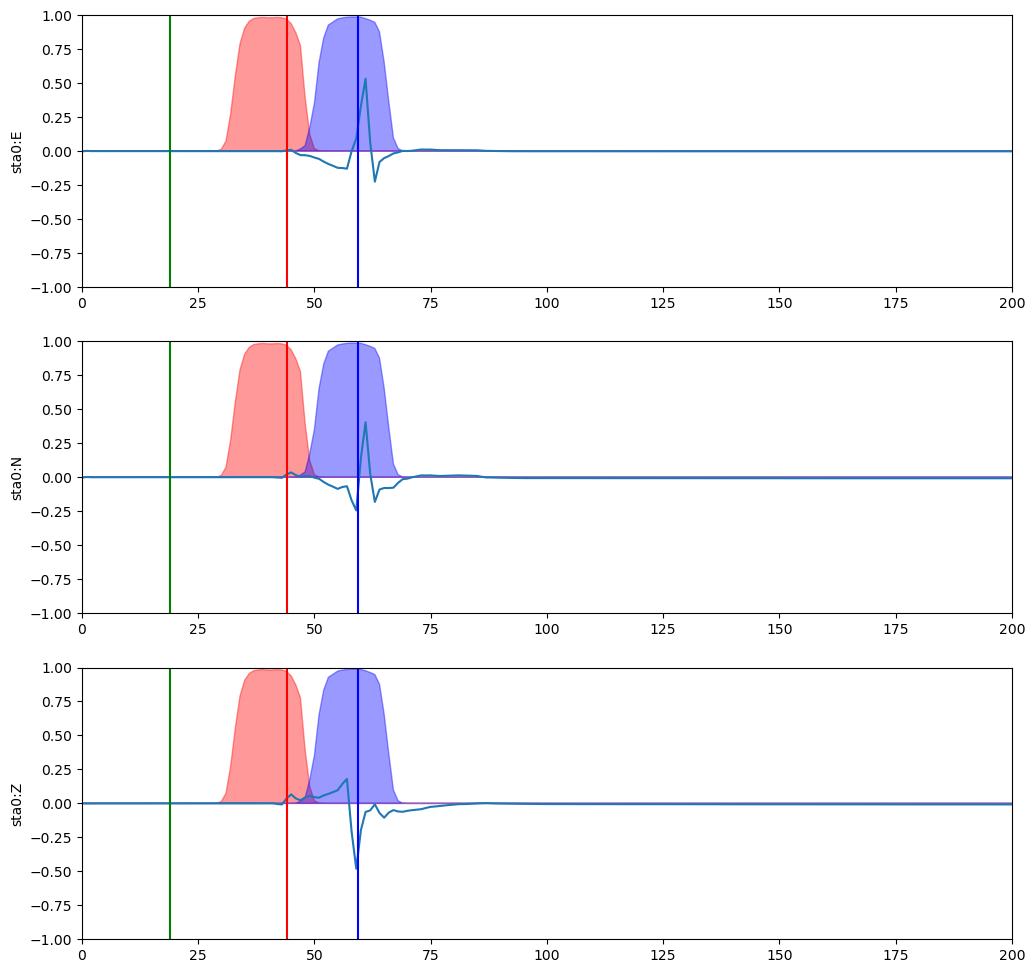

In [ ]:
%matplotlib inline
test_h5_path = '1k_val.hdf5'

transforms = stack_transforms([WtFilter(cl=[-1]),
                                      Normalizer(),
                                      ToTensor(),
                                      ToOneHot(),])

test = SynthSeism(h5_path = test_h5_path, transforms=transforms)

test_dl = DataLoader(dataset=test,
                      batch_size=len(test),
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

loss =  MySparseBCELoss(sparcity = 0.0025)
model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)

# the path from the last save
pt_path = 'model_states/Aug_1_2xNoise_01_01_Drops_state_dict_03_24_2023__18_11_59.pt'
model.load_state_dict(torch.load(pt_path, map_location=torch.device(device)))

l= eval_model(model, test_dl)

# just for pics
x,y = test[42]
y_hat = model(x.unsqueeze(0).to(device)).squeeze(0)
plot_sta('sta0', x, y, y_hat.detach().cpu().numpy())

## Проверка модели на устойчивость к шуму

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1000000.0 <> Loss 2.2095930576324463


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 100 <> Loss 1.812438726425171


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 30 <> Loss 1.077607274055481


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 10 <> Loss 1.184807538986206


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 5 <> Loss 1.3213310241699219


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 3 <> Loss 1.4553254842758179


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 2 <> Loss 1.6544532775878906


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1 <> Loss 2.6638286113739014


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1000000.0 <> Loss 0.5047680735588074


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 100 <> Loss 0.18803496658802032


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 30 <> Loss 0.16108690202236176


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 10 <> Loss 0.1715095043182373


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 5 <> Loss 0.39507704973220825


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 3 <> Loss 1.6930876970291138


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 2 <> Loss 3.289313554763794


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1 <> Loss 5.500546932220459


KeyError: 'aug'

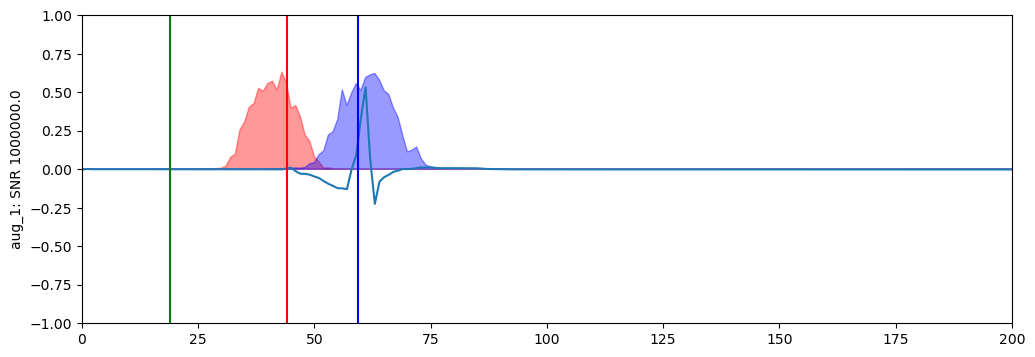

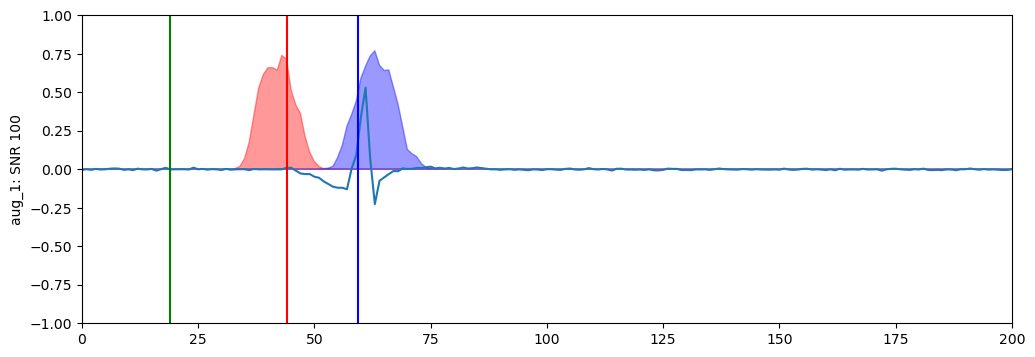

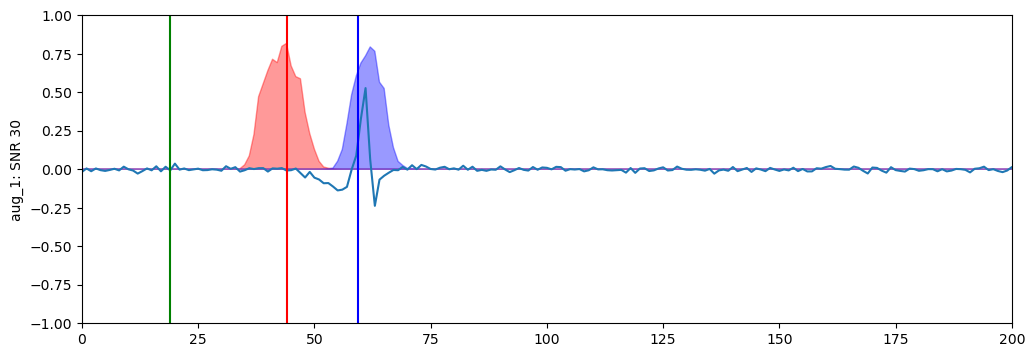

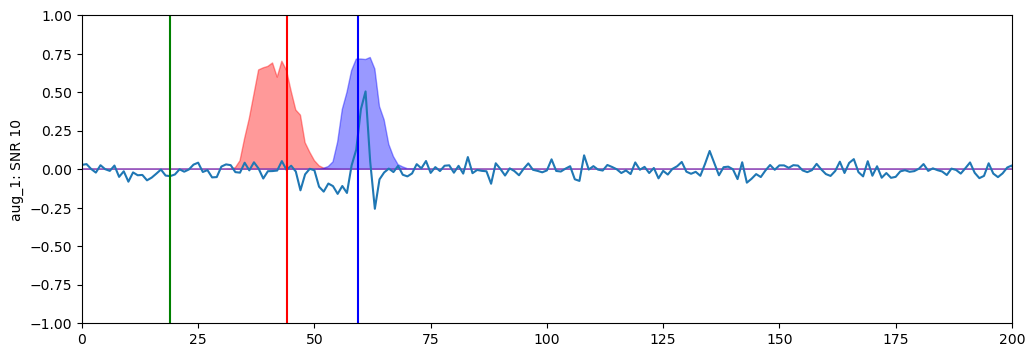

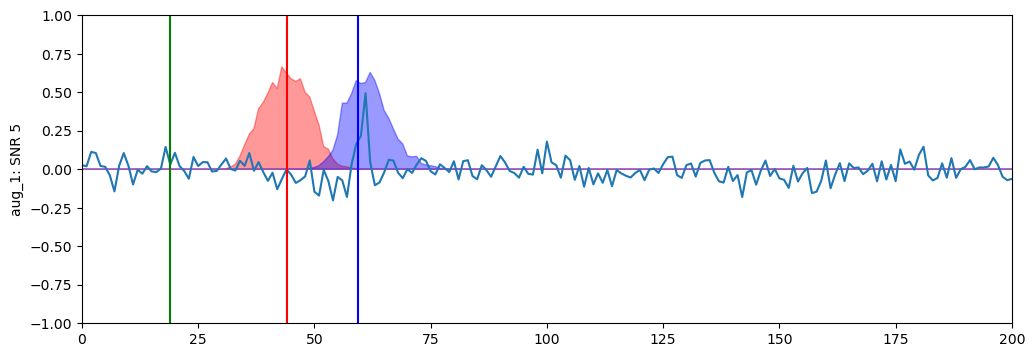

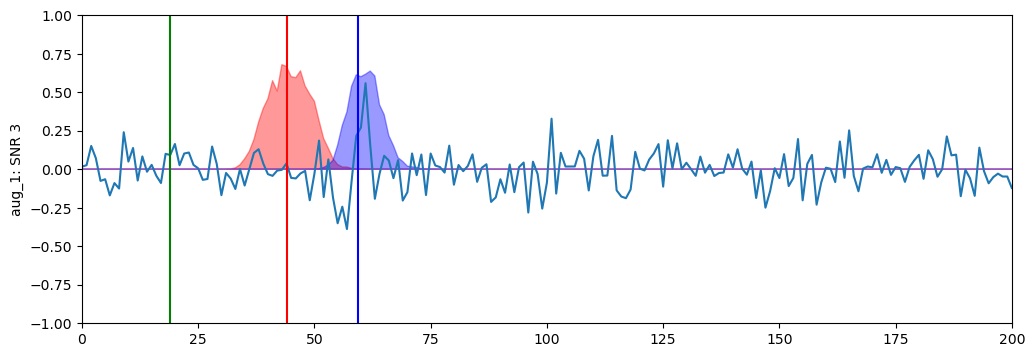

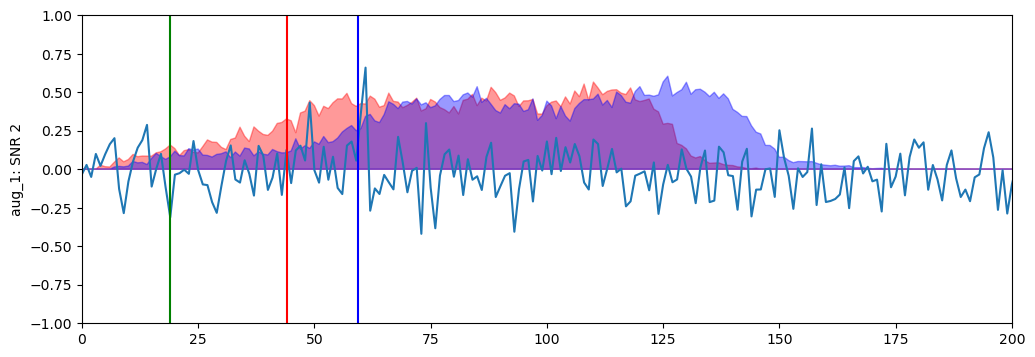

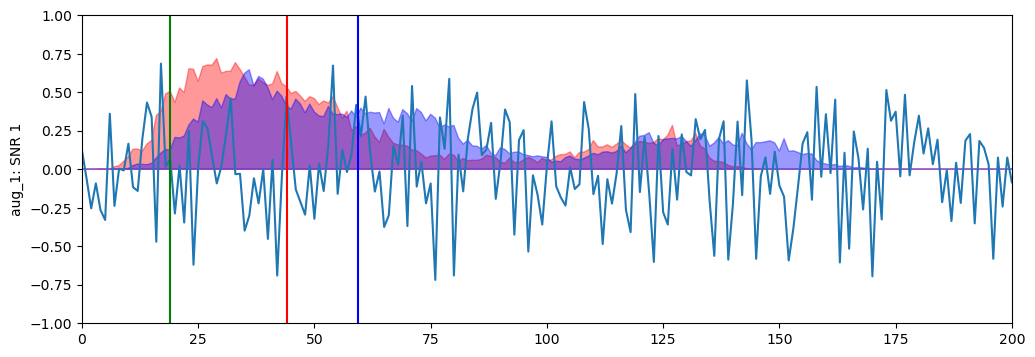

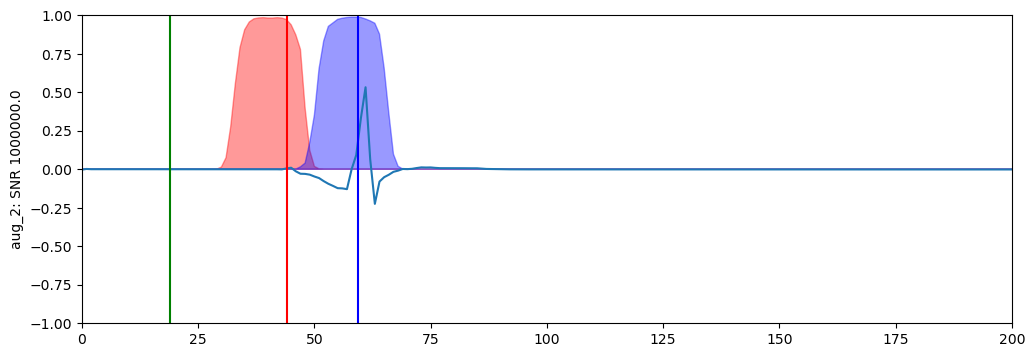

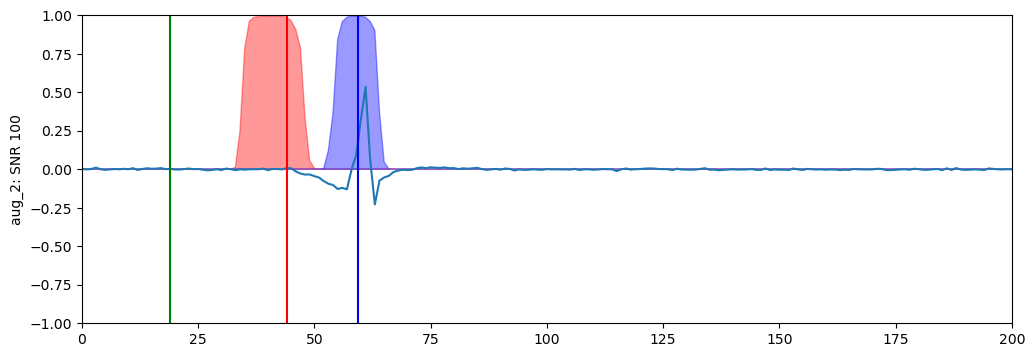

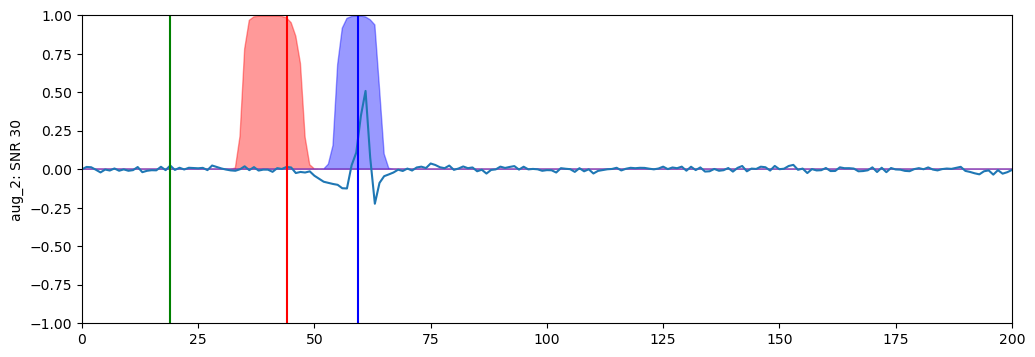

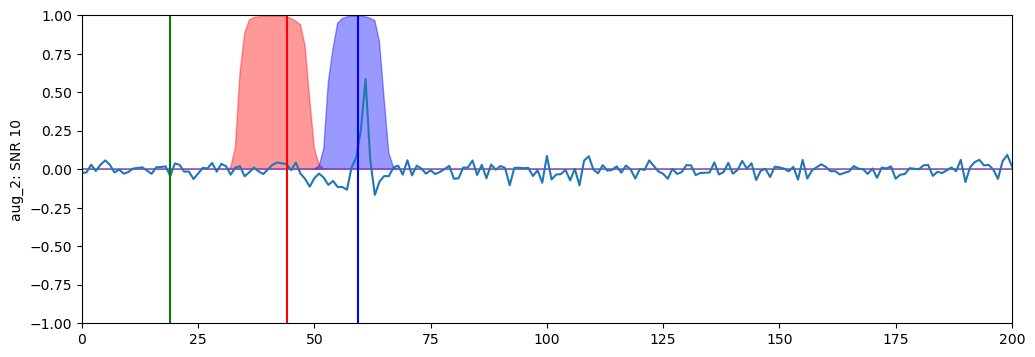

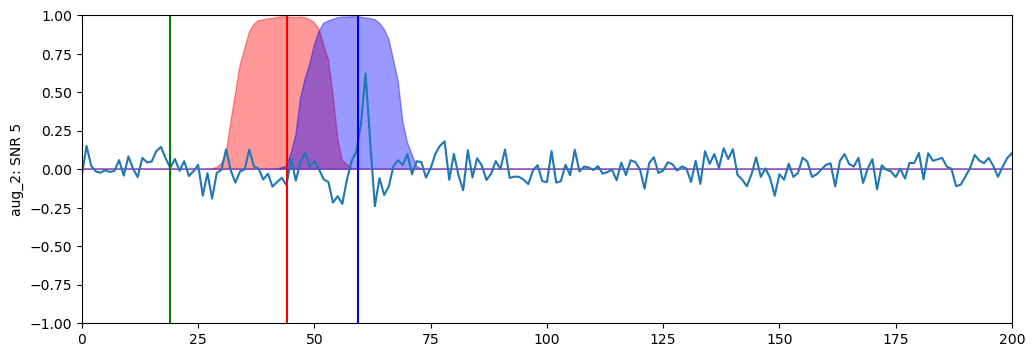

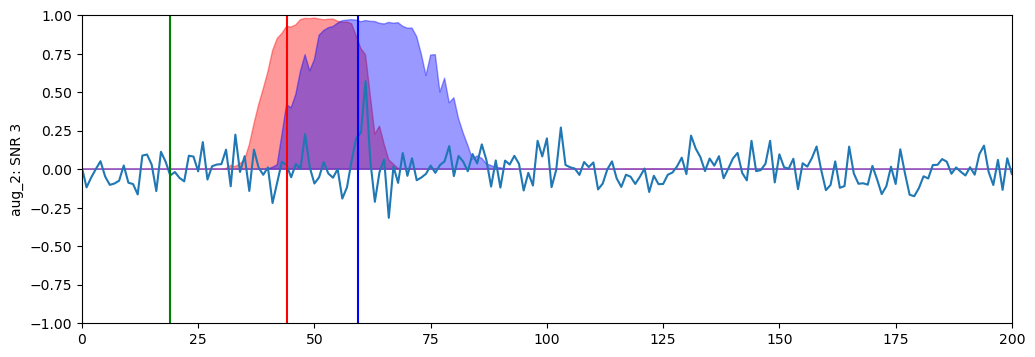

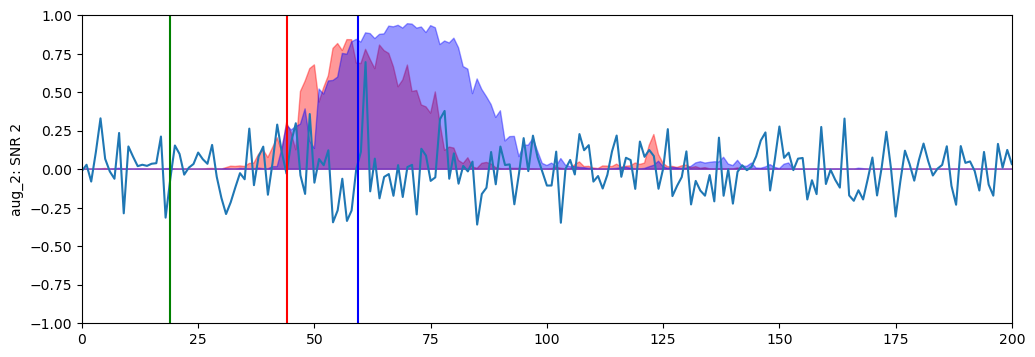

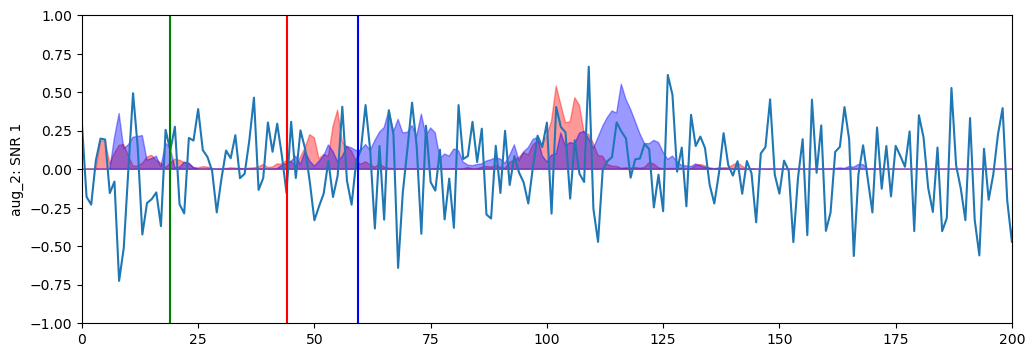

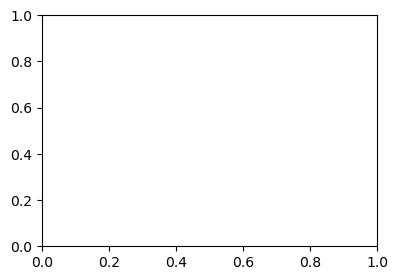

In [ ]:
%matplotlib inline
test_h5_path = '1k_val.hdf5'
loss =  MySparseBCELoss(sparcity = 0.0025)
model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)

pt_path_1 = 'model_states/Aug_1_e3_03_01_state_dict_03_23_2023__17_36_28.pt' # augmentation
pt_path_2 = 'model_states/Aug_1_2xNoise_01_01_Drops_state_dict_03_24_2023__18_11_59.pt' # augmebtation

SNR = [1e6, 100, 30, 10, 5, 3, 2, 1] # SNR = max(|x|)/(3 sigma)
sigmas =[(s**-1)/3 for s in SNR]

mode = ['aug_1', 'aug_2']
losses = {mode[0]:[], mode[1]:[]}
paths = {mode[0]:pt_path_1, mode[1]:pt_path_2}

for m in mode:
    for i, s in enumerate(tqdm(sigmas)):
        model.load_state_dict(torch.load(paths[m], map_location=torch.device(device)))
        transforms = stack_transforms([WtFilter(cl=[-1]), Normalizer(), ToTensor(), ToOneHot(), AddNoize(s)])
        test = SynthSeism(h5_path = test_h5_path, transforms=transforms)
        test_dl = DataLoader(dataset=test, batch_size=len(test), shuffle=False, collate_fn=dataset.collate_fn)
        l = eval_model(model, test_dl)
        losses[m].append(l)

        # just for pics
        x,y = test[42]
        y_hat = model(x.unsqueeze(0).to(device)).squeeze(0).detach().cpu().numpy()
        print(f"SNR {SNR[i]} <> Loss {l}")

        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(x[0][0])
        ax.axvline(x=y['arrivals'][0][0]*100, color='g', label = 'strike') # strike moment
        ax.axvline(x=y['arrivals'][0][1]*100, color='r', label = 'p - wave') # p-wave arrival
        ax.fill_between(np.arange(400), y_hat[0][0], color='r', alpha = 0.4)
        ax.axvline(x=y['arrivals'][0][2]*100, color='b', label = 's - wave') # s-wave arrival
        ax.fill_between(np.arange(400), y_hat[0][1], color='b', alpha = 0.4)
        ax.set_ylabel(f'{m}: SNR {SNR[i]}')
        ax.set_xlim(0,200)
        ax.set_ylim(-1,1)


fig, ax = plt.subplots(1,1, figsize=(4.33, 3))
ax.plot(SNR, losses[mode[0]], label=f'{mode[0]} loss')
ax.plot(SNR, losses[mode[1]], label=f'{mode[1]} loss')
ax.set_title('Loss over SNR', loc='center', fontsize=12)
ax.set_xlabel('SNR', fontsize=12)
ax.set_xlim(0,10)
ax.legend()

## Модель для определения расстояния до источника. 
* На самом деле самое интересное уже произошло при поиске вступлений, задача вычисления расстояния/координат по имеющейся разметке вступлений особой сложности не представляет (в той постановке, что была при первоначальном моделировании). Следующая модель нужна главным образом для того, чтобы получить понятные метрики качества предыдущей модели - погрешность в метрах.
* На вход модели подаётся времена прихода фаз, полученные из основной модели, на выходе получается массив с расстояниями от источника сигнала до каждой станции. На самом деле всё, что требуется от модели - понять, что искомой расстояние пропорционально разнице времён прихода фаз. В будущем эту модель необходимо будет заменить на модель с детекцией отдельных сигналов.

In [ ]:
class SourceToTargetDist(nn.Module):
    '''
    arrivals -> source to target distances
    input: (batch, sta, self.phases, self.rec_len) for 2 phases
    output: (batch, sta, float:dist)
    '''
    def __init__(self, rec_len, phases=2, scale=1000, sampl_rate=100):
        super().__init__()
        self.rec_len = rec_len
        self.phases = phases
        self.scale = scale # to make it more stable
        self.sampl_rate = sampl_rate
        self.timeline = 1 + torch.arange(self.rec_len, device=device)/self.sampl_rate # to help it to figure out the meaning of x
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.phases*self.rec_len, self.phases*self.rec_len)
        self.fc2 = nn.Linear(self.phases*self.rec_len, 1)

    def forward(self, x):
        sh_x = x.shape
        x = x.view(-1, self.rec_len)
        x = x*x*(x+self.timeline) # mask
        x = x.view(-1, self.phases, self.rec_len).flatten(-2,-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unflatten(0, (sh_x[0], sh_x[1])).squeeze(-1)
        return  x * self.scale

### Функции для обучения модели вычисления расстояния от источника до группы станций
При обучении в модель для определения расстояния с заданной вероятностью подаются выходы модели определения вступлений фаз, либо соответствующие векторы из таргета. Это должно помочь лучше обучить модель. 

In [ ]:
def train_one_epoch(dist_model, arr_model, train_dl, test_dl):
    loaders = {'train': train_dl, 'val': test_dl}
    model_modes = {'train': dist_model.train, 'val': dist_model.eval}
    losses = {'train': [], 'val': []}
    for mode in ['train', 'val']:
        model_modes[mode]() # model to train() or eval()
        for X, y_list_of_dicts in tqdm(loaders[mode]):
            y = torch.stack([yy['source_to_target_dist'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
            X = X.to(device)

            if mode == 'train' and coin_flip(p=0.0):
                # ground true arrivals
                arr = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) 
            else:
                # arrivals from model
                arr = arr_model(X) # arrivals

            y_hat = dist_model(arr) # distances
            l = loss(y_hat, y)
            if mode == 'train':
                optimizer.zero_grad()
                l.backward()
                optimizer.step()

        losses[mode] = torch.sqrt(l).item() # squre root of loss == sigma (m)
        
    return losses

def train_dist_model(dist_model, arr_model, train_dl, test_dl):
    metrics = {'loss':{'train': [], 'val': []},
               'epoch': []} 
    
    dist_model.to(device)
    arr_model.requires_grad_(False)
    arr_model.to(device)
    arr_model.eval()

    for epoch in tqdm(range(epochs)):
        losses = train_one_epoch(dist_model, arr_model, train_dl, test_dl)
        metrics['epoch'].append(epoch)
        metrics['loss']['train'].append(losses['train'])
        metrics['loss']['val'].append(losses['val'])
        if epoch % 1 == 0:
            print(f"Epoch {epoch}:: train loss: {metrics['loss']['train'][-1]:.04f}, val loss: {metrics['loss']['val'][-1]:.04f}")

    return metrics

def eval_dist_model(dist_model, arr_model, test_dl, use_arr_model=True):
    arr_model.requires_grad_(False)
    arr_model.to(device)
    arr_model.eval()

    dist_model.requires_grad_(False)
    dist_model.to(device)
    dist_model.eval()

    for X, y_list_of_dicts in tqdm(test_dl):
        y = torch.stack([yy['source_to_target_dist'].to(device) for yy in y_list_of_dicts]) # target is a dict with all staf
        X = X.to(device)
        if use_arr_model:
            # arrivals from model
            arr = arr_model(X)
        else:
            # ground true arrivals
            arr = torch.stack([yy['oh_arrivals'].to(device) for yy in y_list_of_dicts]) 
            

        y_hat = dist_model(arr) # distances
        l = loss(y_hat, y)

    return torch.sqrt(l).item()

def coin_flip(p=0.5, base=1000):
    i = torch.randint(0, base, (1,)).item()
    return i < p * base


### Создание экземпляров моделей

In [ ]:
# arrivals
arr_model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)

# loading state
pt_path = 'model_states/Aug_1_e3_03_01_state_dict_03_23_2023__17_36_28.pt'
arr_model.load_state_dict(torch.load(pt_path, map_location=torch.device(device)))

# distances
dist_model = SourceToTargetDist(rec_len=400, sampl_rate = dataset.sampl_rate)

### Обучение, валидация

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:: train loss: 207.9795, val loss: 232.0903


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:: train loss: 212.6505, val loss: 211.8570


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2:: train loss: 174.7943, val loss: 201.7388


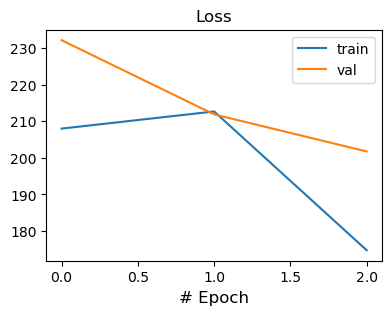

In [ ]:
train_h5_path = '100k_train.hdf5'
test_h5_path = '1k_val.hdf5'

transforms = stack_transforms([WtFilter(cl=[-1]), Normalizer(), ToTensor(), ToOneHot()])

train = SynthSeism(h5_path = train_h5_path, transforms=transforms)
test = SynthSeism(h5_path = test_h5_path, transforms=transforms)

# this is for testing
# train = torch.utils.data.Subset(train, torch.randperm(2000).tolist())

train_dl = DataLoader(dataset=train,
                      batch_size=100,
                      shuffle=True,
                      collate_fn=dataset.collate_fn, 
                      )

test_dl = DataLoader(dataset=test,
                      batch_size=len(test),
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

# loss
loss =  nn.MSELoss(reduction = 'mean')

# optimizer
epochs = 3
lr = 0.0001 
optimizer = torch.optim.Adam(dist_model.parameters(), lr=lr)

metrics = train_dist_model(dist_model, arr_model, train_dl, test_dl)
plot_metrics(metrics)

In [ ]:
#saving path
# !mkdir -p /content/model_states/
pt_path = 'model_states/'+'distance_model_state_dict_'+ datetime.now().strftime("%m_%d_%Y__%H_%M_%S") +'.pt'
torch.save(dist_model.state_dict(), pt_path)

# copy it to gdrive
# !mkdir -p /gdrive/MyDrive/seismo_datasets/model_states/ && cp {pt_path} /gdrive/MyDrive/seismo_datasets/model_states/

## Проверка модели определения расстояния до источника на устойчивость к шуму

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1000 <> Loss 252.98924255371094


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 100 <> Loss 291.7685546875


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 30 <> Loss 267.5528869628906


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 10 <> Loss 319.03912353515625


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 5 <> Loss 384.6946716308594


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 3 <> Loss 482.7597351074219


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 2 <> Loss 586.9061279296875


  0%|          | 0/1 [00:00<?, ?it/s]

SNR 1 <> Loss 774.888427734375


Text(0.5, 0, 'SNR')

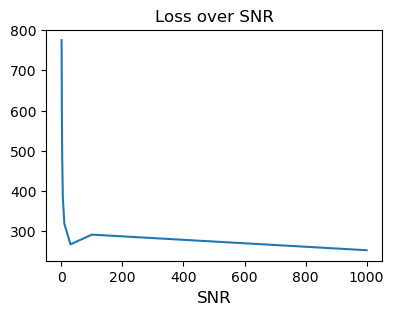

In [ ]:
%matplotlib inline
test_h5_path = '1k_val.hdf5'

loss =  nn.MSELoss(reduction = 'mean')

arr_model = Arrivals(chanels=3, rec_len=400, one_tr_attn_nlayer=1, sta_attn_nlayer=1, J=3, Q=4)
arr_pt_path = 'model_states/Aug_1_e3_03_01_state_dict_03_23_2023__17_36_28.pt'
arr_model.load_state_dict(torch.load(arr_pt_path, map_location=torch.device(device)))

dist_model = SourceToTargetDist(rec_len=400, sampl_rate=100)
dist_pt_path = 'model_states/distance_model_state_dict_03_23_2023__23_01_10.pt'
dist_model.load_state_dict(torch.load(dist_pt_path, map_location=torch.device(device)))

SNR = [1e6, 100, 30, 10, 5, 3, 2, 1] # SNR = max(|x|)/(3 sigma)

sigmas = [(s**-1)/3 for s in SNR]

losses = []

for i, s in enumerate(tqdm(sigmas)):
    
    transforms = stack_transforms([WtFilter(cl=[-1]), Normalizer(), ToTensor(), ToOneHot(), AddNoize(s)])
    
    test = SynthSeism(h5_path = test_h5_path, transforms=transforms)
    
    test_dl = DataLoader(dataset=test,
                      batch_size=len(test),
                      shuffle=False,
                      collate_fn=dataset.collate_fn, 
                      )

    l= eval_dist_model(dist_model, arr_model, test_dl, use_arr_model=True)
    losses.append(l) # sqrt for meters
    print(f"SNR {SNR[i]} <> Loss {l}")

fig, ax = plt.subplots(figsize=(4.33, 3))
ax.plot(SNR, losses, label='STD error (m)')
ax.set_title('Loss over SNR', loc='center', fontsize=12)
ax.set_xlabel('SNR', fontsize=12)

## Дальше всякие рабочие моменты, связынные с отладкой. В работе программы не используются.

torch.Size([10, 5, 3, 16, 50])


Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

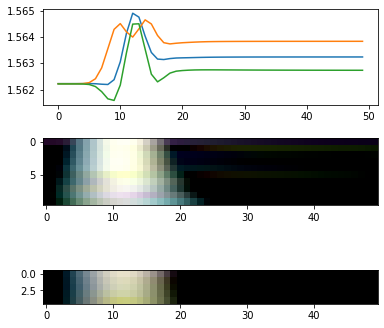

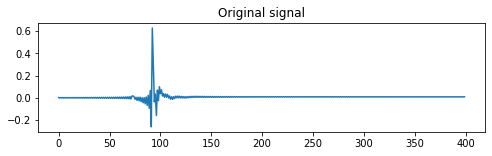

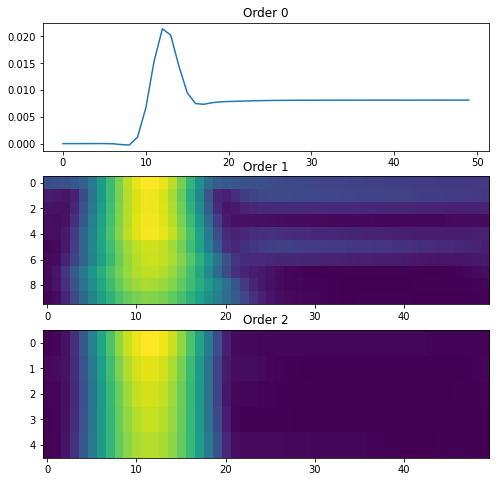

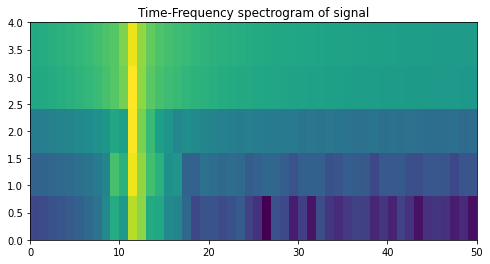

In [ ]:
sc = LogScat(J=3, N=X.shape[-1], Q=4)

Sx, meta = sc(X)
print(Sx.shape)

img = Sx[0][0]
mean, std = torch.mean(img), torch.std(img)
img  = ((img-mean)/std +0.5)/2
# m = nn.Sigmoid()
# img= m(img)
fig, ax = plt.subplots(3,1, figsize=(6, 6))
ax[0].plot(img.permute(1, 2, 0).numpy()[0])
ax[1].imshow(img.permute(1, 2, 0).numpy()[1:11])
ax[2].imshow(img.permute(1, 2, 0).numpy()[11:])


order = [np.where(meta['order'] == order) for order in [0,1,2]]
x = X[0][0][0]

# signal
plt.figure(figsize=(8, 2))
plt.plot(x)
plt.title('Original signal')

# 0 order
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(Sx[0][0][0][order[0]][0])
plt.title('Order 0')

# 1-2 order
for ii in [1,2]:
    plt.subplot(3, 1, ii+1)
    plt.imshow(Sx[0][0][0][order[ii]], aspect='auto')
    plt.title(f'Order {ii}')

plt.figure(figsize=(8, 4))
plt.specgram(x, Fs=8, NFFT=8, noverlap=0, detrend='mean')
plt.title("Time-Frequency spectrogram of signal")

In [ ]:
meta
# https://github.com/kymatio/kymatio/blob/main/kymatio/scattering1d/filter_bank.py
# psi(t) = g_{sigma}(t) (e^{i xi t} - kappa)
# central frequency
# 'xi': normalized center frequency, where 0.5 corresponds to Nyquist.
# about meta https://github.com/kymatio/kymatio/blob/main/kymatio/scattering1d/frontend/base_frontend.py

{'order': array([0, 1, 1, 1, 1, 2, 2, 2]), 'xi': array([[    nan,     nan],
        [0.35   ,     nan],
        [0.175  ,     nan],
        [0.0875 ,     nan],
        [0.04375,     nan],
        [0.35   , 0.04375],
        [0.175  , 0.04375],
        [0.0875 , 0.04375]]), 'sigma': array([[       nan,        nan],
        [0.14013095,        nan],
        [0.07006547,        nan],
        [0.03503274,        nan],
        [0.01751637,        nan],
        [0.14013095, 0.01751637],
        [0.07006547, 0.01751637],
        [0.03503274, 0.01751637]]), 'j': array([[nan, nan],
        [ 0., nan],
        [ 0., nan],
        [ 0., nan],
        [ 1., nan],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]), 'n': array([[nan, nan],
        [ 0., nan],
        [ 1., nan],
        [ 2., nan],
        [ 3., nan],
        [ 0.,  3.],
        [ 1.,  3.],
        [ 2.,  3.]]), 'key': [(),
  (0,),
  (1,),
  (2,),
  (3,),
  (0, 3),
  (1, 3),
  (2, 3)]}

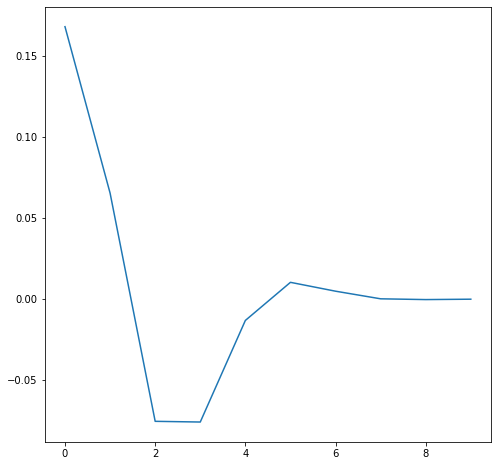

In [ ]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory
from scipy.fft import fft, ifft, fftfreq

# psi(t) = g_{sigma}(t) (e^{i xi t} - kappa)

T=2**12
J=10
Q= (1,1)
phi_f, psi1_f, psi2_f = scattering_filter_factory(T, J, Q, T)

yf = psi1_f[1]['levels'][0]

plt.figure(figsize=(8, 8))
plt.plot(ifft(yf)[0:10])

In [ ]:
psi1_f

[{'levels': [array([ 0.00000000e+00,  7.51697631e-07,  1.50340807e-06, ...,
          -2.25501565e-06, -1.50335645e-06, -7.51684434e-07])],
  'xi': 0.35,
  'sigma': 0.14013094769175247,
  'j': 0},
 {'levels': [array([-5.21180213e-18,  1.50466153e-06,  3.00937422e-06, ...,
          -4.51367769e-06, -3.00916961e-06, -1.50461038e-06])],
  'xi': 0.175,
  'sigma': 0.07006547384587623,
  'j': 0},
 {'levels': [array([-5.21180212e-18,  3.00937421e-06,  6.01895304e-06, ...,
          -9.02689503e-06, -6.01813461e-06, -3.00916961e-06])],
  'xi': 0.0875,
  'sigma': 0.03503273692293812,
  'j': 0},
 {'levels': [array([-5.21180212e-18,  6.01895304e-06,  1.20387246e-05, ...,
          -1.80519488e-05, -1.20354509e-05, -6.01813461e-06])],
  'xi': 0.04375,
  'sigma': 0.01751636846146906,
  'j': 1},
 {'levels': [array([-5.21180212e-18,  1.20387246e-05,  2.40807233e-05, ...,
          -3.60965333e-05, -2.40676284e-05, -1.20354509e-05])],
  'xi': 0.021875,
  'sigma': 0.00875818423073453,
  'j': 2},
 {'le

### Sakhalin dataset operations (not used yet)



In [ ]:
h5_path = '/content/data/SAKH-2014_2021_global_norm.h5'
with h5py.File(h5_path, 'r') as f:
    X, Y = (f['X'][:], f['Y'][:])

trace_no = 0 # event
chnlz= [0, 1, 2] # chanels

fig, ax = plt.subplots(3,1, figsize=(8,6*2))
with h5py.File(h5_path, 'r') as f:
    for ii in chnlz:
        ax[ii].plot(f[f"X"][trace_no][:,ii])
        ax[ii].set_title(f'Label: {f["Y"][trace_no]}') # 0 = p, 1 = s, 2 = noise ?


In [ ]:

def num_to_one_hot(num, size):
    lo_int = torch.floor(num)
    hi_int = torch.ceil(num)
    lo_val = hi_int - num
    hi_val = num - lo_int
    ss = size * torch.ones_like(num)
    sp = torch.sparse_coo_tensor(torch.cat((lo_int, hi_int), dim=-1), torch.cat((lo_val, hi_val), dim=-1), size=ss)
    return sp.to_dense()



x = torch.tensor([[[1.1, 2.5, 3.4], [4.6,2.5,5.2]], [[2.5,7.5,9.7], [2.5, 5,3.8]]])
ssize = 15

def make_my_tricky_oh(x, oh_size):
    # my mind is blowing
    lo_int = torch.floor(x)
    hi_int = torch.ceil(x)
    lo_val = hi_int - x
    hi_val = x - lo_int
  
    xs = x.to_sparse_coo()
    ii = xs.indices()
    ss = xs.size()
    # new indieces
    flo_int = lo_int.view(1,-1)
    lo_ii = torch.cat((ii, flo_int))
    fhi_int = hi_int.view(1,-1)
    hi_ii = torch.cat((ii, fhi_int))
    new_ii = torch.cat((lo_ii, hi_ii), dim=-1)
    # new values
    lo_vv = lo_val.view(-1)
    hi_vv = hi_val.view(-1)
    new_vv = torch.cat((lo_vv, hi_vv), dim=-1)
    # new size
    new_ss = list(ss)
    new_ss.append(oh_size)
    # sparse to dense
    my_new_shiny_sparse_tensor = torch.sparse_coo_tensor(new_ii, new_vv, new_ss)
    my_georgious_oh = my_new_shiny_sparse_tensor.to_dense()
    return my_georgious_oh

make_my_tricky_oh(x, 20)

tensor([[[[0.0000, 0.9000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.6000, 0.4000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 0.6000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0

old transforms

In [ ]:
def filtering(tr, wt='db2', calcelled_levels = [-1]):
    '''som wavelet filtering, not sure about it yet'''
    coeffs = pywt.wavedec(tr, wt, mode='constant')
    for ii in calcelled_levels:
        coeffs[ii] = np.zeros_like(coeffs[ii])
    tr_hat = pywt.waverec(coeffs, wt)
    
    return tr_hat

def transforms(traces, targets):
    # filtration
    # no cl == no filtering
    traces = filtering(traces, calcelled_levels = [])

    # normalization
    # every event (stack of 5*3 traces) is normalized on max ampl. separately 
    # because of very large span of ampls. (~8 orders of degree).
    # norm goes into targets['params']['signal_max']
    max_abs = np.max(np.abs(traces))
    traces = traces/max_abs
    targets['params'].update({'signal_max': max_abs.item()})

    # to tensors
    traces = torch.tensor(traces, dtype=torch.float)
    targets['arrivals'] = torch.tensor(targets['arrivals'], dtype=torch.float) 
    targets['source_to_target_dist'] = torch.tensor(targets['source_to_target_dist'], dtype=torch.float)

    # arrivals -> one hot tensors
    # this is for future expansion for working with continuous traces.
    # result goes to targets['oh_arrivals']
    s_rate = targets['params']['s_rate'] # 100 Hz
    arr = targets['arrivals'] # seconds
    arr = arr[:,1:] # NO STRIKE INFO, just p and s
    tr_len = traces.shape[-1] # trace len
    arr = torch.floor(arr*s_rate).long() # floor because arrival is the last zero sampl

    # for future me: torch.sparse_coo_tensor is better to be there
    oh_arrivals = F.one_hot(arr, num_classes=tr_len).float()
    targets.update({'oh_arrivals': oh_arrivals})  

    return traces, targets

In [ ]:
# splitting the dataset into the train and test set
torch.manual_seed(1)
set_size = len(dataset)
test_share = 0.01
rand_idxs = torch.randperm(set_size).tolist()

train = torch.utils.data.Subset(dataset, rand_idxs[:-int(test_share*set_size)])
test = torch.utils.data.Subset(dataset, rand_idxs[-int(test_share*set_size):])
